# Reinforcement Learning to Control a Robot Arm

This notebook is on based a reinforcement learning assignment in Professor Chuck Anderson's machine learning course (CS545) at Colorado State University and is shared here with his permission. Changes to the original notebook include:

* Neural network implementation in `Pytorch`, including GPU set up
* Augmented state functions to include polar coordinates
* Variable goal states

The Robot class and state functions have been slightly modified to allow for random goal generation, otherwise the `Robot` class and `state` code is left as is from the assignment.

## Overview of problem setup

This notebook walks through a Reinforcement Learning (RL) set up for a simulation of a two-dimensional robot arm with multiple links and joints. A neural network is used to approximate the Q function to predict the reinforcements from each action given a state. The reinforcement is the distance to a goal for the end of the robot's arm, and lower reinforcements are better.

The state of the arm is the angles of each joint. Joint angles are represented with the sine and cosine of the angle, to deal with the discontinuity between 1 and 359 degrees, as the state input to the neural network. The addition of polar coordinates to the state is also tested to see if this helps learning. Valid actions on each step will be $-0.1$, $0$, and $+0.1$ applied to each joint.

The Q function is modeled with neural network built using `Pytorch`, this is refered to as the `Qnet` throughout the notebook. The Pytorch implementation includes flags for running on the `cpu` and `gpu`.  Model architecture is defined in the `MLP` class and the number and size of layers is defined dynamically using inputs to the call to the constructor. Normalization layers are also added by default to help with model training. Traditional data normalization is challenging in RL models since the training data is generated during training and we don't know the means and standard deviations before training. Adding layer normalization seems to have helped in this regard by improving the accuracy and speed of training.

After initial testing of the training functions, a parameter grid search is performed in order to find a good model that can handle a variable goal state. Training results are sorted by the mean reinforcement, R, for the last 20 training trials and the model with the lowest mean reinforcement is selected as the best model. Plots and animations are constructed to visualize training the performance of the combinations of parameters.

## Set up

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import itertools  # for product (cross product)
from math import pi
from IPython.display import display, clear_output
import time
import joblib

In [2]:
# set plot size parameter
plt.rcParams["figure.figsize"] = (8,4.5)

Import packages for model training.

In [3]:
# import dl and ml packages
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import ParameterGrid
from datetime import datetime

In [4]:
# see if the GPU is available 
torch.cuda.is_available()

True

In [5]:
# current gpu device number
torch.cuda.current_device()

0

In [6]:
# This will set the device based on the GPUs availability
# the device will be updated later to test running on the GPU and CPU
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = "cuda:" + str(torch.cuda.current_device())
else:  
    device = "cpu"
    
print(device)

cuda:0


# `Robot` Class

Here is an implementation of the robot simulation:

In [7]:
class Robot():

    def __init__(self, link_lengths):
        self.n_links = len(link_lengths)
        self.record_angles = False
        self.angles = []
        self.link_lengths = np.array(link_lengths)
        self.joint_angles = np.zeros(self.n_links)
        self.points = [[10, 10] for _ in range(self.n_links + 1)]
        self.lim = sum(link_lengths)
        self.update_points()
        self.goal = None

    def set_goal(self, g):
        self.goal = g
        
    def set_rand_goal(self):
        theta = np.random.uniform(0, 2*pi)
        radius = np.random.uniform(0, self.lim * 1.1)
        x = radius*np.cos(theta)
        y = radius*np.sin(theta)
        self.goal = [x+10,y+10]
        return None
    
    def get_goal(self):
        return self.goal
    
    def get_theta_r_goal(self):
        goal = robot.get_goal()
        goal = [goal[0]-10, goal[1]-10]
        theta = np.arctan2(goal[0],goal[1])-pi/2
        r = np.sqrt(np.sum(goal)**2)
        return [theta, r]

    def dist_to_goal(self):
        return np.sqrt(np.sum((self.goal - self.end_effector)**2))
    
    def update_joints(self, joint_angles):
        self.joint_angles = joint_angles
        self.update_points()

    def add_to_joints(self, joint_angle_deltas):
        
        if isinstance(joint_angle_deltas, torch.Tensor):
            joint_angle_deltas = joint_angle_deltas.numpy()
        
        self.joint_angles += joint_angle_deltas
        too_high = self.joint_angles > 2 * pi
        self.joint_angles[too_high] = self.joint_angles[too_high] - 2 * pi
        too_low = self.joint_angles < 0
        self.joint_angles[too_low] = self.joint_angles[too_low] + 2 * pi
        if self.record_angles:
            self.angles.append(self.joint_angles * 180 / pi)
        self.update_points()

    def update_points(self):
        for i in range(1, self.n_links + 1):
            self.points[i][0] = (self.points[i - 1][0]
                                 + self.link_lengths[i - 1] * np.cos(np.sum(self.joint_angles[:i])))
            self.points[i][1] = (self.points[i - 1][1] +
                                 self.link_lengths[i - 1] * np.sin(np.sum(self.joint_angles[:i])))
        self.end_effector = np.array(self.points[self.n_links]).T

    def get_angles(self):
        return self.joint_angles
    
    def get_link_lengths(self):
        return self.link_lengths
        
    def plot(self, style):
        for i in range(self.n_links + 1):
            if i is not self.n_links:
                plt.plot([self.points[i][0], self.points[i + 1][0]],
                         [self.points[i][1], self.points[i + 1][1]], style)
            plt.plot(self.points[i][0], self.points[i][1], 'k.')
        plt.axis('off')
        plt.axis('square')
        plt.xlim([-1, 21])
        plt.ylim([-1, 21])

    def animate(self, n_steps, Qnet=None, state_f=None, show_all_steps=False, device='cpu'):
        fig = plt.figure(figsize=(8, 8))
        
        for i in range(n_steps):
            if not show_all_steps:
                fig.clf()
            plt.scatter(self.goal[0], self.goal[1], s=80)
            if Qnet:
                action, Qvalue = epsilon_greedy(self, Qnet, valid_actions, state_f, epsilon=0, device=device)
            else:
                action = [0.1] * self.n_links
                
            self.add_to_joints(action)
            style = 'b-' if show_all_steps and i+1 == n_steps else 'r-'
            self.plot(style)
            
            if not show_all_steps:
                clear_output(wait=True)
                display(fig)
            
        if not show_all_steps:
            clear_output(wait=True)

To use this class, first instantiate a robot by specifying the number of links and the lengths of each link as a list.  Imagine the end of the last link of the robot has a gripper. Set the goal location for the gripper by calling `robot.set_goal()`.  

Then you can animate the robot for some number of steps.

In [8]:
robot = Robot([4, 3])
#robot.set_goal([10, 10])
robot.set_rand_goal()
print(robot.get_goal())

[16.24906468621839, 14.06989453272259]


In [9]:
# goal in polar coordinates
robot.get_theta_r_goal()

[-0.5772749325481227, 10.318959218940979]

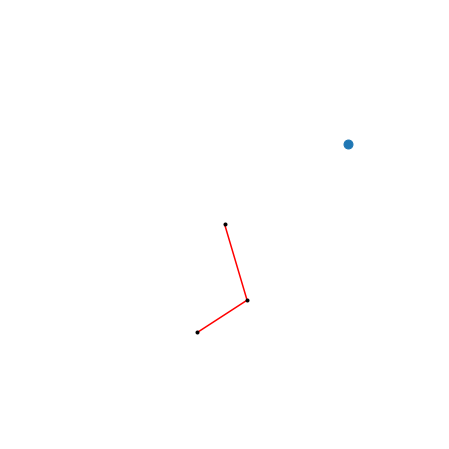

In [10]:
# animate the robot for 50 steps
robot.animate(50)

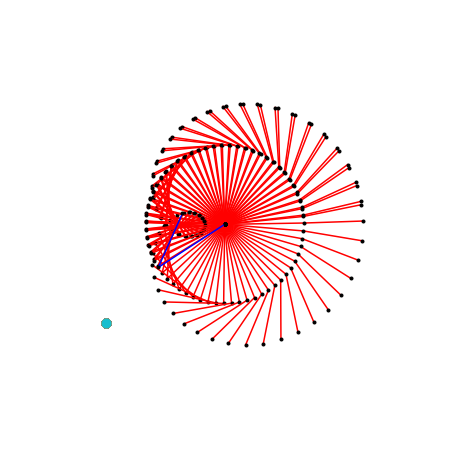

In [11]:
# trace the steps of the robot
robot = Robot([4, 3])
robot.set_goal([4, 5])
robot.animate(100, show_all_steps=True)

# Reinforcement Learning Problem for Controlling the Robot

From the original assignment:

    To define the reinforcement learning problem for controlling this robot and trying to move the gripper as close to the goal as you can, we need to define the three main functions that define a reinforcement learning problem. These are pretty easy with the functions available to us in the `Robot` class. We will also need a function to represent the joint angles as sines and cosines.
    
State functions with `*_w_angles` were added. These functions add the polar coordinates to the state, thus they return the Cartesian and polar coordinates for the state and the goal.

In [12]:
def angles_to_sin_cos(angles):
    return np.hstack((np.sin(angles), np.cos(angles)))

def get_state(robot):
    state = np.hstack([angles_to_sin_cos(robot.get_angles()), robot.get_goal()]) 
    return state

def get_state_w_angles(robot):
    state = np.hstack([get_state(robot), # in cartesian coords
                       robot.get_angles(), robot.get_link_lengths(), robot.get_theta_r_goal()]) 
    return state

def initial_state(robot):
    robot.update_joints(np.random.uniform(-2 * pi, 2 * pi, size=(robot.n_links)))
    angles = robot.get_angles()
    state = np.hstack([angles_to_sin_cos(robot.get_angles()), robot.get_goal()]) 
    return state

def initial_state_w_angles(robot):
    angles = robot.get_angles()
    state = initial_state(robot)
    angles = robot.get_angles()
    state_w_state_angles = np.hstack([state, angles, robot.get_link_lengths(), robot.get_theta_r_goal()]) 
    return state_w_state_angles

def next_state(robot, action):
    robot.add_to_joints(action)
    angles = robot.get_angles()
    state = np.hstack([angles_to_sin_cos(robot.get_angles()), robot.get_goal()])
    return state

def next_state_w_angles(robot, action):
    state = next_state(robot, action)
    angles = robot.get_angles()
    state_w_angles = np.hstack([state, angles, robot.get_link_lengths(), robot.get_theta_r_goal()])
    return state_w_angles


def reinforcement(robot):
    '''Objective is to move gripper to the goal location as quickly as possible.'''
    dist_to_goal = robot.dist_to_goal()
    return dist_to_goal

In [13]:
# set up state functions dictionary to pass into training functions
def get_state_functions(polar_coord):
    if polar_coord:
        initial_state_f = initial_state_w_angles
        next_state_f = next_state_w_angles
        state_f = get_state_w_angles
    else:
        initial_state_f = initial_state
        next_state_f = next_state
        state_f = get_state
        
    return {'initial_state_f':initial_state_f, 
            'next_state_f':next_state_f,
           'state_f':state_f}

The two main functions used in the simulations are `epsilon_greedy` and `make_samples`.  `make_samples` creates a specified number steps for each training trial.  For each step in the trial, `make_samples` calls `epsilon_greedy` which uses the `Qnet` to predict the `R` for each action given the current state. If a greedy action is selected, then the action with the lowest predicted `R` is returned; otherwise, a random action is returned. These random actions help to explore the state-action space. Early in training, most actions are random, allowing the `Qnet` to gain experience in the space. But as training progresses, most actions are greedy.

`epsilon_greedy` is also used in the `animate` function in the `robot` class to get the actions for the animations.

In [14]:
def epsilon_greedy(robot, Qnet, 
                   valid_actions, 
                   state_f, 
                   epsilon, # probablity of a random move
                   device
                  ):
    
    # not using variable goal in training
    # state = angles_to_sin_cos(robot.get_angles())
    
    # send Qnet to appropriate device
    Qnet.to(device)
    
    state = state_f(robot)
    
    if np.random.uniform() < epsilon:
        
        # Random Move
        actioni = np.random.randint(valid_actions.shape[0])
        action = valid_actions[actioni]
        
    else:
        # Greedy Move
        
        state_x = np.tile(state,valid_actions.shape[0]).reshape(valid_actions.shape[0],-1)
        xs = torch.from_numpy(np.hstack([state_x, valid_actions])).float().to(device)
        Qs = Qnet(xs).reshape(-1,1)
        ai = torch.argmin(Qs)
        action = valid_actions[ai]
        
    x = torch.from_numpy(np.hstack((state, action)).reshape((1, -1))).float().to(device)
    Q = Qnet(x)
    
    return action, Q

In [15]:
def make_samples(robot, Qnet, n_inputs, reinforcement_f,
                 valid_actions, n_samples, epsilon, 
                 state_funcs,
                 random_goal=False,
                 device=device):
    
    debug = False
    
    # get state functions from state_func dictionary
    initial_state_f = state_funcs['initial_state_f'] 
    next_state_f = state_funcs['next_state_f'] 
    state_f = state_funcs['state_f']
    
    if debug: print('allocating vectors')
    X = torch.from_numpy(np.zeros((n_samples, n_inputs))).to(device)
    R = torch.from_numpy(np.zeros((n_samples, 1))).to(device)
    Qn = torch.from_numpy(np.zeros((n_samples, 1))).to(device)
    
    if debug: print('setting up state')
    # update random goal
    if random_goal: 
        robot.set_rand_goal()
        
    state = initial_state_f(robot)
    state = next_state_f(robot, [0] * robot.n_links)  # 0 action for all joints
    action, _ = epsilon_greedy(robot, Qnet, valid_actions, state_f, epsilon, device)
    
    
    # Collect data from numSamples steps
    for step in range(n_samples):
        
        if debug: 
            print('_____________')
            print(f'step: {step}')
            print('setting up state')
            
        next_state = next_state_f(robot, action)
        r = reinforcement_f(robot)
        
        if debug: print('epsilon greedy')
        next_action, next_Q = epsilon_greedy(robot, Qnet, valid_actions, state_f, epsilon, device)
        
        if debug: print('save results')
        X[step, :] = torch.from_numpy(np.hstack((state, action)))
        R[step, 0] = r
        Qn[step, 0] = torch.detach(next_Q)
        
        # Advance one time step
        state, action = next_state, next_action

    return (X, R, Qn)

## `MLP` Class

This defines a class to construct an MLP using Pytorch. The inputs to the constructor are a follows:
* input_size: the number of variables in the state-action space (i.e. number of columns in X)
* h_sizes: a list with number of hidden units in each layer, `[20,10]` constructs a two layer model with `20` and `10` hidden units respectively
* n_out: the dimension of the output (i.e. the number of columns in Y)
* act_func: the activation function to use, currently supports "tanh, "elu", "relu", "sigmoid"
* use_layer_norm: Boolean flag for adding layer normalization

The number and size of the layers is dynamically defined using `h_sizes`. In the constructor, this is converted to an `nn.ModuleList`, so the layers will be tracked and the layer weights saved when check pointing the model. The `forward` function calculates a forward pass based the model definition that is used by Pytorch to set up the automatic differentiation in the backwards pass updates. `model_to_dict` is a convenience function to save the model definition to a dictionary, so the model can be recreated from file and the check pointed weights loaded into the model.

In [16]:
# see this excellent article on normalization techniques
# https://mlexplained.com/2018/11/30/an-overview-of-normalization-methods-in-deep-learning/

class MLP(nn.Module):

    def __init__(self, input_size, h_sizes, n_out, act_func = 'tanh', use_layer_norm=True):
    
        '''act_func: one of "tanh, "elu", "relu", "sigmoid"
                     defaults to "tanh"   
        '''
    
        super(MLP, self).__init__()
        
        self.input_size = input_size
        self.h_sizes = h_sizes
        self.n_out = n_out
        self.act_func = act_func
        self.use_layer_norm = use_layer_norm

        
        # Hidden layers
        # use nn.ModuleList() so layers will avaible in state_dict
        self.hidden = nn.ModuleList()
        
        
        # layer normalization layers
        if self.use_layer_norm:
            self.ln = nn.ModuleList()
        else:
            self.ln = None
                
        
        # create a list of layer sizes to use in model construction
        sizes = [input_size] + h_sizes # + [n_out]
        
        
        # build model
        for k in range(len(sizes)-1):
            self.hidden.append(nn.Linear(sizes[k], sizes[k+1]))
            if self.use_layer_norm:
                self.ln.append(nn.LayerNorm(sizes[k+1]))

                
        # Output layer
        self.out = nn.Linear(sizes[-1], self.n_out)
        
        
    # save model architecture to dictionary
    def model_to_dict(self):
        
        model_dict = {'input_size':self.input_size,
                     'h_sizes':self.h_sizes,
                     'n_out':self.n_out,
                     'act_func':self.act_func,
                     'use_layer_norm':self.use_layer_norm}
        
        return(model_dict)

    
    # forward pass calculation
    def forward(self, x):
        
        # set activation function
        if self.act_func == 'elu':
            act = nn.ELU()
        elif self.act_func == 'relu':
            act = nn.ReLU()
        elif self.act_func == 'sigmoid':
            act = nn.Sigmoid()
        else: # default to tanh
            act = nn.Tanh()
        
        
        # x needs to be torch tensor
        if type(x) == 'numpy.ndarray':
            x = torch.from_numpy(x).float()
            
            
        # Feedforward
        for i in range(len(self.hidden)):
            layer = self.hidden[i]
            if self.use_layer_norm:
                ln = self.ln[i]
                x = act(ln(layer(x)))
            else:
                x = act(layer(x))
            
        output= self.out(x)

        return output

In [17]:
test = MLP(10, [20,20], 1, 'elu')
test.model_to_dict()

{'input_size': 10,
 'h_sizes': [20, 20],
 'n_out': 1,
 'act_func': 'elu',
 'use_layer_norm': True}

In [18]:
test.hidden

ModuleList(
  (0): Linear(in_features=10, out_features=20, bias=True)
  (1): Linear(in_features=20, out_features=20, bias=True)
)

In [19]:
test.ln

ModuleList(
  (0): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
  (1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
)

# Reinforcement Learning Training Algorithm

The `train` function wraps up all of the previous work into a function that can be used for setting up training.  Its inputs are:
* robot: member of the robot class to model 
* state_funcs: a dictionary containing the state functions with the keys - 'initial_state_f', 'next_state_f', 'state_f'
* valid_actions: an array of all the permutations of possible actions
* n_hiddens_list: list containing the sizes of the hidden layers
* n_trials: number of training trails to run (i.e, the number of calls to `make_samples`)
* n_steps_per_trial: the number of steps created in each call to `make_samples`
* n_opt_iterations: the number of steps taken by the optimizer after each call to `make_samples`
* final_epsilon: the final probability for taking a random move
* gamma: the discount rate for future reinforcements
* learning_rate: step size for the optimizer
* act_func: activation function to use in the MLP
* random_goal: boolean flag for generating a random goal for run of `make_samples`
* device: GPU or CPU string, like 'cpu' or 'cuda:0'

This function returns the trained Qnet and traces from the training.

In [20]:
# define weights initialization function
# first checks the module type
# then applies the desired changes to the weights
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.uniform_(m.weight)


def train(robot, polar_coord, valid_actions,
          n_hiddens_list,
          n_trials,
          n_steps_per_trial,
          n_opt_iterations,
          final_epsilon,
          gamma, 
          learning_rate,
          act_func='tanh',
          random_goal=False,
          device=device
         ):
        
        
    # get state_funcs based on boolean value of polar_coord
    state_funcs = get_state_functions(polar_coord)
        
        
    # get state functions from state_func dictionary
    initial_state_f = state_funcs['initial_state_f'] 
    next_state_f = state_funcs['next_state_f'] 
    state_f = state_funcs['state_f']
    
    
    # flag for printing losses
    print_losses = False
    
    
    # to produce this final epsilon value
    final_trial_decay = (n_trials-20) if (n_trials-20) > 20 else n_trials
    epsilon_decay = np.exp(np.log(final_epsilon+0.00001) / (final_trial_decay))  
    
    
    # put valid_actions on device
    valid_actions = torch.from_numpy(valid_actions)
    valid_actions.to(device)
    
    
    # instantiate Qnet
    n_inputs = len(initial_state_f(robot)) + valid_actions.shape[1]
    Qnet = MLP(n_inputs, n_hiddens_list, n_out=1, act_func=act_func)
    Qnet.to(device)

    
    # apply the initialization strategy to the model weights
    Qnet.apply(init_normal)
        
    
    # define loss function
    loss_fn = torch.nn.MSELoss(reduction='mean')

    
    # Use the optim module to define an Optimizer that will update the model weights
    optimizer = torch.optim.Adam(Qnet.parameters(), lr=learning_rate)

    
    # initial epsilon value for taking random or greedy actions
    epsilon = 1         
    epsilon_trace = []
    r_mean_trace = []
    r_trace = []
    loss_trace = []
    
    
    print('Starting trials')
    print('______________________________________________\n')
    
    
    # start learning trials
    for trial in range(n_trials):
        
        # Collect n_steps_per_trial samples
        X, R, Qn = make_samples(robot, Qnet, n_inputs, 
                                reinforcement, valid_actions, 
                                n_steps_per_trial, epsilon, 
                                state_funcs,
                                random_goal,
                                device)
        
        # create targets for Qnet
        y = (R + gamma * Qn).float()
    
        # train Qnet
        for t in range(n_opt_iterations):
            
            # Forward pass
            y_pred = Qnet(X.float())

            # Compute and print loss
            loss = loss_fn(y_pred, y)
            
            if print_losses and t % 100 == 99:
                print(t, loss.item())

            # Zero gradients, perform a backward pass, and update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        
        # Update traces
        epsilon_trace = epsilon_trace + [epsilon]
        r_mean_trace = r_mean_trace + [np.mean(R.cpu().numpy())]
        r_trace = r_trace + list(itertools.chain.from_iterable(R))
        loss_trace = loss_trace + [loss_fn(y_pred, y).detach().cpu().numpy()]
        
        
        # Decay epsilon for taking greedy or random actions
        epsilon *= epsilon_decay
        
        
        # print training progress
        n_prints = np.min([250, (n_trials // 10)])
        # if trial + 1 == n_trials or (trial + 1) % (n_trials // 10) == 0:
        if trial + 1 == n_trials or (trial + 1) % (n_prints) == 0:
            r = np.mean(r_mean_trace[-10:])
            l = np.mean(loss_trace[-10:])
            print(f'Trial - {trial+1}: Mean R {r:.3f} - MSE loss {l:.3f}')
             
    return Qnet, state_funcs, r_mean_trace, r_trace, loss_trace, epsilon_trace

## Test Training
* Instantiate robot
* Set up action space
* Get state
* Set training parameters
* Run train function
* Build plots and animations

In [21]:
# set up a matrix of valid actions to choose from
single_joint_actions = [-0.1, 0, 0.1]
valid_actions =  np.array(list(itertools.product(single_joint_actions, repeat=robot.n_links)))
valid_actions

array([[-0.1, -0.1],
       [-0.1,  0. ],
       [-0.1,  0.1],
       [ 0. , -0.1],
       [ 0. ,  0. ],
       [ 0. ,  0.1],
       [ 0.1, -0.1],
       [ 0.1,  0. ],
       [ 0.1,  0.1]])

### Train with a Fixed Goal and without Polar Coordinates

For this first test, I'll train the model without the use of polar coordinates in the state space. I'll run the experiment with a larger number of trials compared to the number of samples in each trial. This will give the model more experience learning the state-action space since the Qnet is updated after each trial. This model will be trained with a fixed goal. Since this is for testing, using a fixed goal will reduced the training time needed to ensure that the components are working correctly. After these tests are completed, then I'll test on a variable goal model.

In [22]:
# instantiate robot and set goal
robot = Robot([3., 3.])
robot.set_goal([5., 6.])

# set up parameters for training
n_hiddens_list = [64, 64]
n_trials = 1000
n_steps_per_trial = 128
n_opt_iterations = 10
final_epsilon = 0.01
gamma = 0.8
learning_rate = 0.001
act_func = 'relu'
random_goal = False
polar_coord = False
device = 'cpu'


In [23]:
# train RL model
np.random.seed(42)
torch.manual_seed(42)

    
t0 = time.time()
Qnet, _, r_mean_trace, _, loss_trace, epsilon_trace = train(robot, polar_coord, valid_actions,
                                                         n_hiddens_list,  
                                                         n_trials,
                                                         n_steps_per_trial, 
                                                         n_opt_iterations,
                                                         final_epsilon, 
                                                         gamma, 
                                                         learning_rate,
                                                         act_func,
                                                         random_goal,
                                                         device
                                                         )
t1 = time.time()

print(f'elapsed minutes: {(t1-t0)/60}')

Starting trials
______________________________________________

Trial - 100: Mean R 4.248 - MSE loss 1.764
Trial - 200: Mean R 1.683 - MSE loss 0.251
Trial - 300: Mean R 1.545 - MSE loss 0.146
Trial - 400: Mean R 1.476 - MSE loss 0.128
Trial - 500: Mean R 1.253 - MSE loss 0.067
Trial - 600: Mean R 1.189 - MSE loss 0.070
Trial - 700: Mean R 1.585 - MSE loss 0.041
Trial - 800: Mean R 1.155 - MSE loss 0.047
Trial - 900: Mean R 0.953 - MSE loss 0.016
Trial - 1000: Mean R 0.956 - MSE loss 0.016
elapsed minutes: 3.12507909933726


In [24]:
device = 'cuda:0'

# train RL model
np.random.seed(42)
torch.manual_seed(42)

    
t0 = time.time()
Qnet, state_funcs, r_mean_trace, _, loss_trace, epsilon_trace = train(robot, polar_coord, valid_actions,
                                                         n_hiddens_list,  
                                                         n_trials,
                                                         n_steps_per_trial, 
                                                         n_opt_iterations,
                                                         final_epsilon, 
                                                         gamma, 
                                                         learning_rate,
                                                         act_func,
                                                         random_goal,
                                                         device
                                                         )
t1 = time.time()

print(f'elapsed minutes: {(t1-t0)/60}')

Starting trials
______________________________________________

Trial - 100: Mean R 4.675 - MSE loss 1.615
Trial - 200: Mean R 1.602 - MSE loss 0.323
Trial - 300: Mean R 1.434 - MSE loss 0.181
Trial - 400: Mean R 1.424 - MSE loss 0.140
Trial - 500: Mean R 1.398 - MSE loss 0.079
Trial - 600: Mean R 1.219 - MSE loss 0.082
Trial - 700: Mean R 1.518 - MSE loss 0.037
Trial - 800: Mean R 1.019 - MSE loss 0.040
Trial - 900: Mean R 1.147 - MSE loss 0.014
Trial - 1000: Mean R 1.002 - MSE loss 0.015
elapsed minutes: 2.6572440028190614


In [25]:
# save experiment in dictionary
experiment_test = {'params':None, 
                'r_mean_trace_list':[r_mean_trace],
                'loss_trace_list':[loss_trace],
                'epsilon_trace_list':[epsilon_trace],
                'robot':robot,
                'best_Qnet_model':Qnet.model_to_dict(),
                'checkpoint':{'state_dict': Qnet.state_dict()}}

#### Test saving and loading Qnet from file

In [26]:
# save model definition and wieghts
torch.save({'state_dict': Qnet.state_dict()}, 'experiment/Qnet_state_test.pth')
joblib.dump(Qnet.model_to_dict(), 'experiment/Qnet_model_test.joblib')

['Qnet_model_test.joblib']

In [27]:
# load dictionary with the model definition for the best Qnet
Qnet_model = joblib.load('experiment/Qnet_model_test.joblib')
Qnet_model

{'input_size': 8,
 'h_sizes': [64, 64],
 'n_out': 1,
 'act_func': 'relu',
 'use_layer_norm': True}

In [28]:
# build model from definition
Qnet = MLP(Qnet_model['input_size'], 
           Qnet_model['h_sizes'],
           Qnet_model['n_out'],
           Qnet_model['act_func'],
           Qnet_model['use_layer_norm'])

Qnet.model_to_dict()

{'input_size': 8,
 'h_sizes': [64, 64],
 'n_out': 1,
 'act_func': 'relu',
 'use_layer_norm': True}

In [29]:
# load model state from best Qnet
checkpoint = torch.load('experiment/Qnet_state_test.pth')

# load model weights from best Qnet
Qnet.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [30]:
# define function to plot experiment
def plot_experiment(experiment, index=0):
    '''experiment is a dictionary containing:
        params - DataFrame containing parameters and Qnet
        r_mean_trace_list - list containing r_mean_traces from trials
        r_trace_list - list containing r_traces from trials
        epsilon_trace_list - list containing epsilon_traces from trials'''
    
    plt.figure(figsize=(10, 10))
    plt.clf()
    plt.subplot(3, 1, 1)
    plt.plot(experiment['r_mean_trace_list'][index])
    plt.xlabel('Trial')
    plt.ylabel('Mean R per Trial')

    plt.subplot(3, 1, 2)
    plt.plot(experiment['loss_trace_list'][index])
    plt.xlabel('Trial')
    plt.ylabel('MSE')

    plt.subplot(3, 1, 3)
    plt.plot(experiment['epsilon_trace_list'][index])
    plt.xlabel('Trial')
    plt.ylabel('Epsilon')

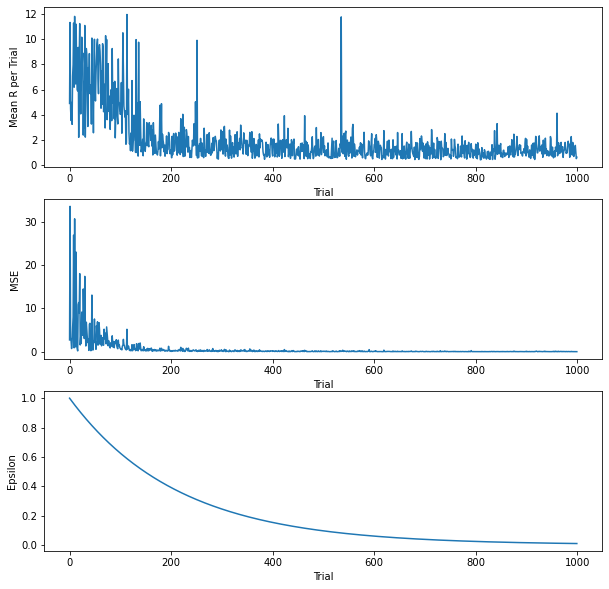

In [31]:
# plot training traces
plot_experiment(experiment_test)

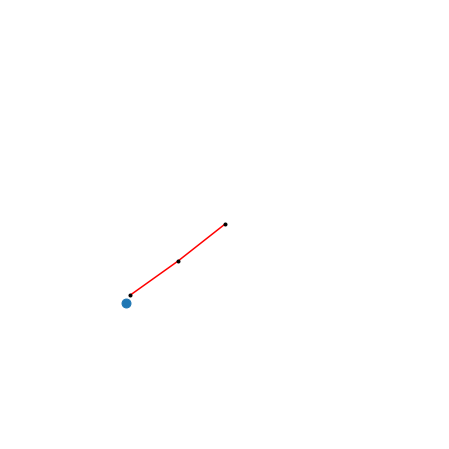

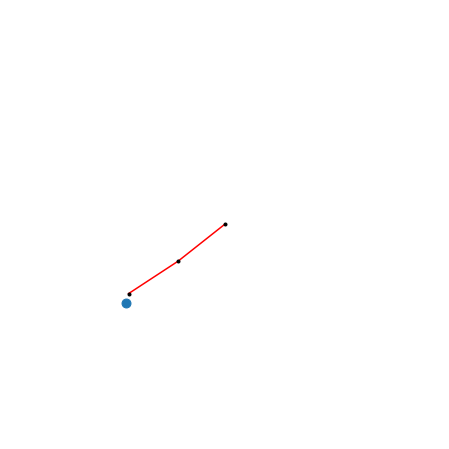

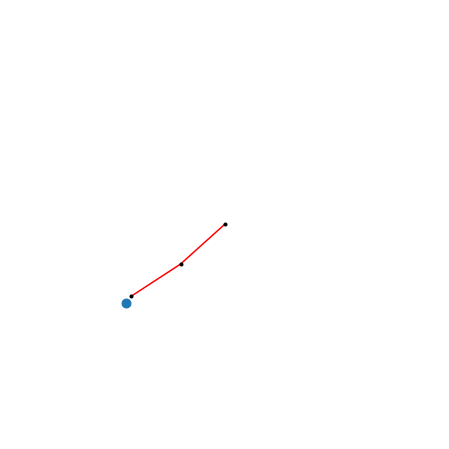

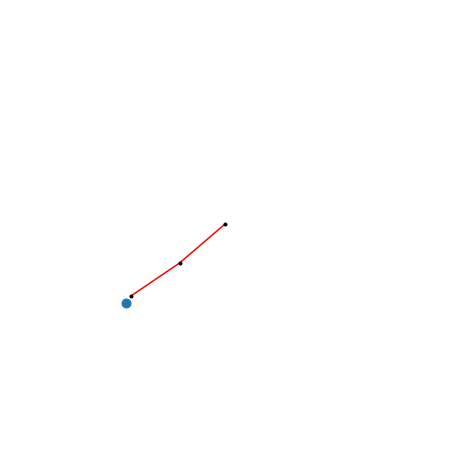

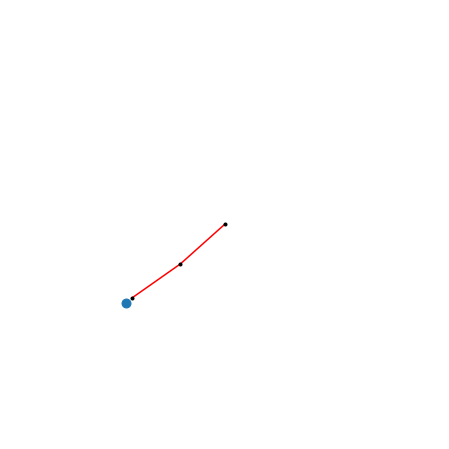

In [32]:
# run robot animations
state_funcs = get_state_functions(polar_coord)
for i in range(5):
    if random_goal:
        robot.set_rand_goal()
    initial_state(robot)
    robot.animate(50, Qnet, state_funcs['state_f'])

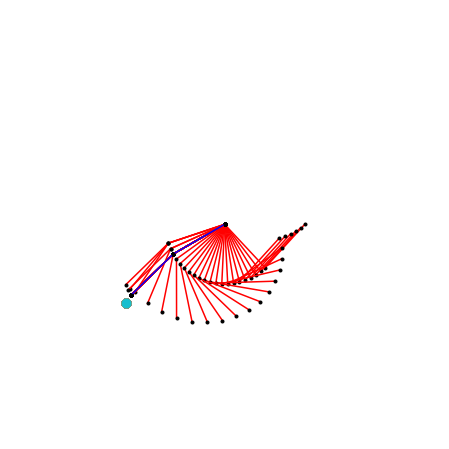

In [33]:
# show trace of animation steps
np.random.seed(4444)
initial_state(robot)
robot.animate(50, Qnet, state_funcs['state_f'], show_all_steps=True)

### Train with a Fixed Goal and with Polar Coordinates

This test will use the same training parameters as the previous test, with the addition of polar coordinates to the state space. I'm curious to see if this extra information will help the Qnet learn the state-action space better and/or faster than only using Cartesian coordinates. In particular, I wonder if the model using only the Cartesian coordinates will have to learn how to approximate some the trigonometric transformations that are included in the polar coordinates. If that's the case, then my thought is that the model my learn faster if it doesn't have to learn these approximations since they are provided in the state space.

In [34]:
# add polar coordinates to state
polar_coord = True

# instantiate robot and set goal
robot = Robot([3., 3.])
robot.set_goal([5., 6.])


# train RL model
np.random.seed(42)
torch.manual_seed(42)
    
t0 = time.time()
Qnet, state_funcs, r_mean_trace, _, loss_trace, epsilon_trace = train(robot, polar_coord, valid_actions,
                                                         n_hiddens_list,  
                                                         n_trials,
                                                         n_steps_per_trial, 
                                                         n_opt_iterations,
                                                         final_epsilon, 
                                                         gamma, 
                                                         learning_rate,
                                                         act_func,
                                                         random_goal,
                                                         device
                                                         )
t1 = time.time()

Starting trials
______________________________________________

Trial - 100: Mean R 5.533 - MSE loss 2.769
Trial - 200: Mean R 2.562 - MSE loss 0.339
Trial - 300: Mean R 1.563 - MSE loss 0.201
Trial - 400: Mean R 1.344 - MSE loss 0.096
Trial - 500: Mean R 1.310 - MSE loss 0.072
Trial - 600: Mean R 1.252 - MSE loss 0.078
Trial - 700: Mean R 2.459 - MSE loss 0.177
Trial - 800: Mean R 1.289 - MSE loss 0.082
Trial - 900: Mean R 1.094 - MSE loss 0.035
Trial - 1000: Mean R 2.018 - MSE loss 0.219


In [35]:
print(f'elapsed minutes: {(t1-t0)/60}')

elapsed minutes: 2.7566214005152383


In [36]:
# save experiment in dictionary
experiment_test = {'params':None, 
                'r_mean_trace_list':[r_mean_trace],
                'loss_trace_list':[loss_trace],
                'epsilon_trace_list':[epsilon_trace],
                'robot':robot,
                'best_Qnet_model':Qnet.model_to_dict(),
                'checkpoint':{'state_dict': Qnet.state_dict()}}

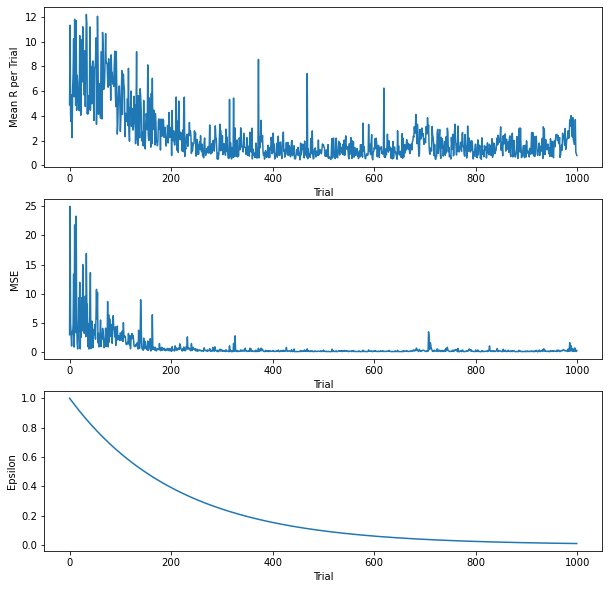

In [37]:
# plot training traces
plot_experiment(experiment_test)

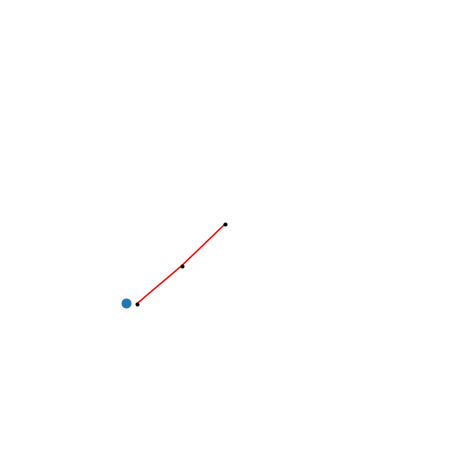

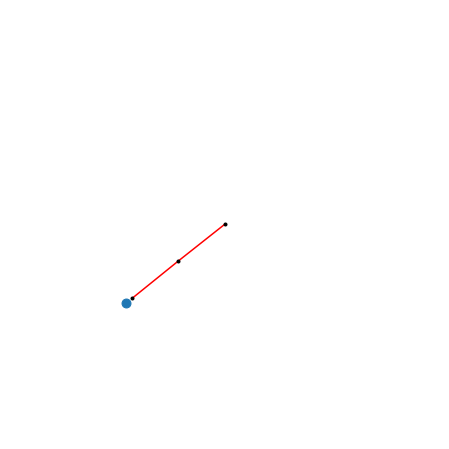

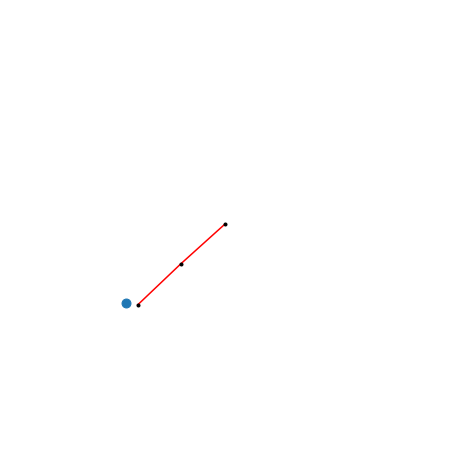

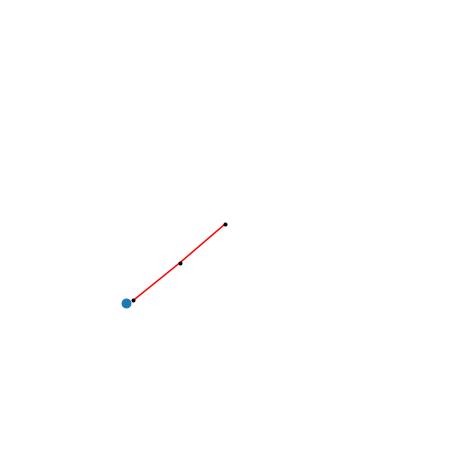

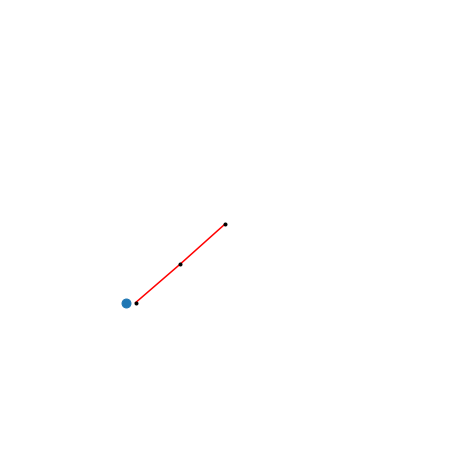

In [38]:
# run robot animations
for i in range(5):
    if random_goal:
        robot.set_rand_goal()
    initial_state(robot)
    robot.animate(50, Qnet, state_funcs['state_f'])

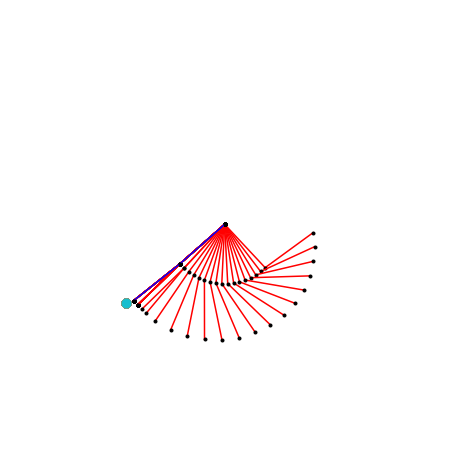

In [39]:
# show trace of animation steps
np.random.seed(4444)
initial_state(robot)
robot.animate(50, Qnet, state_funcs['state_f'], show_all_steps=True)

### Polar Coordinate Test Results

With this initial testing, the polar coordinates did not provide a substantial improvement in learning. I'll test training with polar coordinates with a larger model to see if increasing model complexity will allow it to make better use of the additional information.

### Train with Variable Goal

To train the model with a variable goal, I will increase the number of trials and steps per trials and train a larger network. Since the Qnet updates after every trial, this will allow the model to explore and learn the more complex state-action space that now includes a moving goal and polar coordinates. 

In [256]:
# instantiate robot and set goal
robot = Robot([3., 3.])
robot.set_goal([5., 6.])

# set up parameters for training
n_hiddens_list = [256, 256]
n_trials = 10000
n_steps_per_trial = 256
n_opt_iterations = 35
final_epsilon = 0.001
gamma = 0.8
learning_rate = 0.001
act_func = 'elu'
random_goal = True
polar_coord = True
device = 'cuda:0'


In [257]:
# train RL model
np.random.seed(42)
torch.manual_seed(42)

    
t0 = time.time()
Qnet, state_funcs, r_mean_trace, _, loss_trace, epsilon_trace = train(robot, polar_coord, valid_actions,
                                                         n_hiddens_list,  
                                                         n_trials,
                                                         n_steps_per_trial, 
                                                         n_opt_iterations,
                                                         final_epsilon, 
                                                         gamma, 
                                                         learning_rate,
                                                         act_func,
                                                         random_goal,
                                                         device
                                                         )
t1 = time.time()

Starting trials
______________________________________________

Trial - 250: Mean R 4.761 - MSE loss 0.386
Trial - 500: Mean R 2.994 - MSE loss 0.236
Trial - 750: Mean R 2.104 - MSE loss 0.103
Trial - 1000: Mean R 1.685 - MSE loss 0.080
Trial - 1250: Mean R 0.882 - MSE loss 0.035
Trial - 1500: Mean R 1.255 - MSE loss 0.033
Trial - 1750: Mean R 1.035 - MSE loss 0.037
Trial - 2000: Mean R 0.989 - MSE loss 0.029
Trial - 2250: Mean R 0.678 - MSE loss 0.029
Trial - 2500: Mean R 0.897 - MSE loss 0.018
Trial - 2750: Mean R 0.793 - MSE loss 0.029
Trial - 3000: Mean R 0.556 - MSE loss 0.015
Trial - 3250: Mean R 0.673 - MSE loss 0.013
Trial - 3500: Mean R 0.659 - MSE loss 0.022
Trial - 3750: Mean R 0.662 - MSE loss 0.013
Trial - 4000: Mean R 0.714 - MSE loss 0.012
Trial - 4250: Mean R 0.630 - MSE loss 0.007
Trial - 4500: Mean R 0.643 - MSE loss 0.006
Trial - 4750: Mean R 0.710 - MSE loss 0.011
Trial - 5000: Mean R 0.586 - MSE loss 0.006
Trial - 5250: Mean R 2.199 - MSE loss 0.049
Trial - 5500: M

In [258]:
print(f'elapsed minutes: {(t1-t0)/60}')

elapsed minutes: 61.97686067422231


In [259]:
np.mean(r_mean_trace[-20:])

0.7033519700138309

In [260]:
# save experiment in dictionary
experiment_test = {'params':None, 
                'r_mean_trace_list':[r_mean_trace],
                'loss_trace_list':[loss_trace],
                'epsilon_trace_list':[epsilon_trace],
                'robot':robot,
                'best_Qnet_model':Qnet.model_to_dict(),
                'checkpoint':{'state_dict': Qnet.state_dict()}}

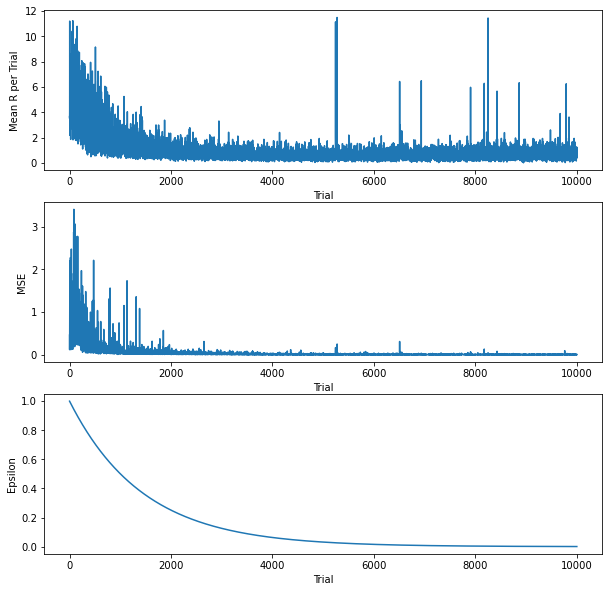

In [261]:
# plot training traces
plot_experiment(experiment_test)

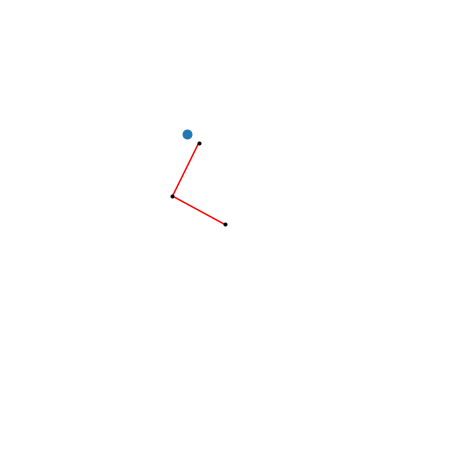

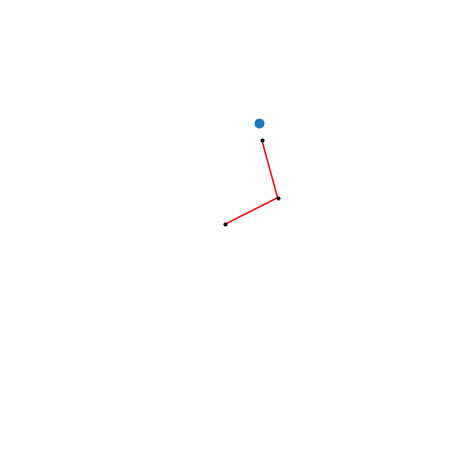

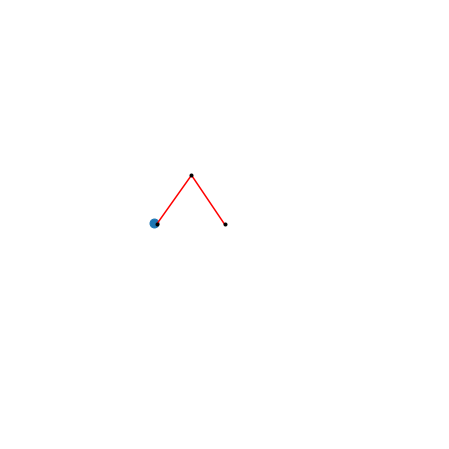

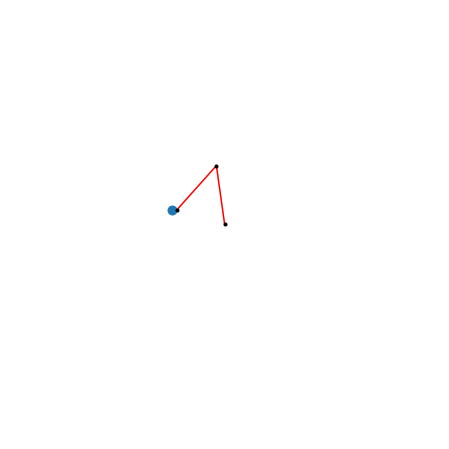

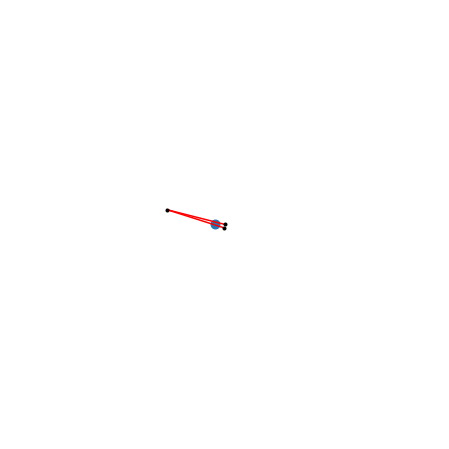

In [262]:
# run robot animations
for i in range(5):
    if random_goal:
        robot.set_rand_goal()
    initial_state(robot)
    robot.animate(50, Qnet, state_funcs['state_f'])

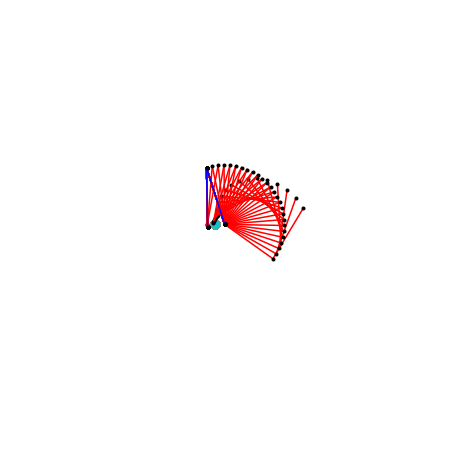

In [263]:
# show trace of animation steps
np.random.seed(4444)
# get state_funcs based on boolean value of polar_coord
state_funcs = get_state_functions(polar_coord)
initial_state(robot)
robot.animate(100, Qnet, state_funcs['state_f'], show_all_steps=True)

# RL Experiments
* Instantiate robot
* Set up parameter grid for model selection
* Train over parameter grid 
    * Save best model definition and state during training
* Load best model
    * Generate plots
    * Generate animations
    
See https://docs.nvidia.com/deeplearning/performance/dl-performance-fully-connected/index.html#checklist for tips to improve GPU performance.  From the documentation:

    ...choosing the batch size and the number of inputs and outputs to be divisible by at least 64 and ideally 256 can streamline tiling and reduce overhead...
    
Steps per trials is works like a batch size, so I'll set the steps per trial to be divisible by 64 as well as the number of nodes in the hidden layers.

In [264]:
# instantiate robot
robot = Robot([3., 3.])
robot.set_goal([5., 6.])

In [266]:
# create a parameter grid to search over
random_goal = True
polar_coord = [True, False]
device = 'cuda:0'


# set up lists of parameters to search over
n_hiddens_list = [
    [256, 256],
    [512, 512],
    [768, 768],
#     [1024, 1024]
]

n_trials = [10000]
n_steps_per_trial = [256]
n_opt_iterations = [15, 35, 75]
final_epsilon = [0.01]
gamma = [0.8]
learning_rate = [0.001]
act_func = ['elu'] # 'relu', 'sigmoid' , 'elu', 'tanh'

    
grid = {
    'polar_coord' : polar_coord,
    'n_hiddens_list' : n_hiddens_list,
    'n_trials' : n_trials,
    'n_steps_per_trial' : n_steps_per_trial,
    'n_opt_iterations' : n_opt_iterations,
    'final_epsilon' : final_epsilon,
    'gamma' : gamma,
    'learning_rate' : learning_rate,
    'act_func' : act_func,

}


# create parameter grid
params = ParameterGrid(grid)
params = pd.DataFrame(params)
params['mean_last_20_r'] = None
params['state_funcs'] = None


# allocate lists to hold traces from training
r_mean_trace_list = [None] * params.shape[0]
loss_trace_list = [None] * params.shape[0]
epsilon_trace_list = [None] * params.shape[0]


params

,act_func,final_epsilon,gamma,learning_rate,n_hiddens_list,n_opt_iterations,n_steps_per_trial,n_trials,polar_coord,mean_last_20_r,state_funcs
0,elu,0.01,0.8,0.001,"[256, 256]",15,256,10000,True,None,None
1,elu,0.01,0.8,0.001,"[256, 256]",15,256,10000,False,None,None
2,elu,0.01,0.8,0.001,"[256, 256]",35,256,10000,True,None,None
3,elu,0.01,0.8,0.001,"[256, 256]",35,256,10000,False,None,None
4,elu,0.01,0.8,0.001,"[256, 256]",75,256,10000,True,None,None
5,elu,0.01,0.8,0.001,"[256, 256]",75,256,10000,False,None,None
6,elu,0.01,0.8,0.001,"[512, 512]",15,256,10000,True,None,None
7,elu,0.01,0.8,0.001,"[512, 512]",15,256,10000,False,None,None
8,elu,0.01,0.8,0.001,"[512, 512]",35,256,10000,True,None,None
9,elu,0.01,0.8,0.001,"[512, 512]",35,256,10000,False,None,None


In [267]:
# it seems wastefull to not to checkpoint the models instead of running all
# all the separate number of trials, i.e. for [500, 1000] trials just checkpoint
# the 500 trial and run only 1000 trials but this ignores the differences in
# epsilon decay between 500 and 1000 trials, a model checkpointed at 500 trials
# will taking more random actions than a model designed for 500 trials

best_last_20 = np.inf
t0 = time.time()

for i in range(params.shape[0]):
    
    np.random.seed(42)
    torch.manual_seed(42)
    
    
    print('______________________________________________________________________\n')
    print(f'Working on row: {i}')
    display(params.iloc[i,:])

    Qnet, state_funcs, r_mean_trace, _, loss_trace, epsilon_trace = train(robot, 
                                                         params.polar_coord[i], 
                                                         valid_actions,
                                                         params.n_hiddens_list[i],  
                                                         params.n_trials[i],
                                                         params.n_steps_per_trial[i], 
                                                         params.n_opt_iterations[i],
                                                         params.final_epsilon[i],  
                                                         params.gamma[i],
                                                         params.learning_rate[i],
                                                         params.act_func[i],
                                                         random_goal,
                                                         device
                                                         )

    # save traces
    r_mean_trace_list[i] = r_mean_trace
    loss_trace_list[i] = loss_trace
    epsilon_trace_list[i] = epsilon_trace
    
    
    # get mean of the last 20 average Rs
    params.loc[i,'mean_last_20_r'] = np.mean(r_mean_trace[-20:])
    
    
    # update best score and save Qnet to file
    if best_last_20 > params.loc[i,'mean_last_20_r']:
        # save Qnet model structure and state
        torch.save({'state_dict': Qnet.state_dict()}, 'experiment/best_Qnet_state.pth')
        joblib.dump(Qnet.model_to_dict(), 'experiment/best_Qnet_model.joblib')
        
        # update best score
        best_last_20 = params.loc[i,'mean_last_20_r']
        
        
    print(f'\nMean of average R for last 20 trials: {params.mean_last_20_r[i]}')
    print(f'Best of average R for last 20 trials: {best_last_20}\n')
    
t1 = time.time()


______________________________________________________________________

Working on row: 0


act_func                    elu
final_epsilon              0.01
gamma                       0.8
learning_rate             0.001
n_hiddens_list       [256, 256]
n_opt_iterations             15
n_steps_per_trial           256
n_trials                  10000
polar_coord                True
mean_last_20_r             None
state_funcs                None
Name: 0, dtype: object

Starting trials
______________________________________________

Trial - 250: Mean R 5.191 - MSE loss 2.257
Trial - 500: Mean R 3.784 - MSE loss 1.231
Trial - 750: Mean R 2.134 - MSE loss 0.400
Trial - 1000: Mean R 2.677 - MSE loss 0.487
Trial - 1250: Mean R 1.483 - MSE loss 0.187
Trial - 1500: Mean R 1.580 - MSE loss 0.198
Trial - 1750: Mean R 1.332 - MSE loss 0.189
Trial - 2000: Mean R 1.782 - MSE loss 0.452
Trial - 2250: Mean R 1.439 - MSE loss 0.133
Trial - 2500: Mean R 0.850 - MSE loss 0.168
Trial - 2750: Mean R 0.982 - MSE loss 0.131
Trial - 3000: Mean R 0.950 - MSE loss 0.091
Trial - 3250: Mean R 0.629 - MSE loss 0.056
Trial - 3500: Mean R 0.899 - MSE loss 0.056
Trial - 3750: Mean R 0.691 - MSE loss 0.032
Trial - 4000: Mean R 0.851 - MSE loss 0.056
Trial - 4250: Mean R 1.042 - MSE loss 0.048
Trial - 4500: Mean R 0.765 - MSE loss 0.035
Trial - 4750: Mean R 0.633 - MSE loss 0.047
Trial - 5000: Mean R 1.028 - MSE loss 0.051
Trial - 5250: Mean R 0.790 - MSE loss 0.044
Trial - 5500: M

act_func                    elu
final_epsilon              0.01
gamma                       0.8
learning_rate             0.001
n_hiddens_list       [256, 256]
n_opt_iterations             15
n_steps_per_trial           256
n_trials                  10000
polar_coord               False
mean_last_20_r             None
state_funcs                None
Name: 1, dtype: object

Starting trials
______________________________________________

Trial - 250: Mean R 5.276 - MSE loss 2.682
Trial - 500: Mean R 3.662 - MSE loss 1.423
Trial - 750: Mean R 2.649 - MSE loss 1.038
Trial - 1000: Mean R 3.222 - MSE loss 0.719
Trial - 1250: Mean R 2.153 - MSE loss 0.331
Trial - 1500: Mean R 3.137 - MSE loss 0.389
Trial - 1750: Mean R 2.376 - MSE loss 0.245
Trial - 2000: Mean R 2.404 - MSE loss 0.334
Trial - 2250: Mean R 2.254 - MSE loss 0.451
Trial - 2500: Mean R 1.978 - MSE loss 0.211
Trial - 2750: Mean R 1.834 - MSE loss 0.205
Trial - 3000: Mean R 2.435 - MSE loss 0.316
Trial - 3250: Mean R 1.782 - MSE loss 0.166
Trial - 3500: Mean R 2.182 - MSE loss 0.392
Trial - 3750: Mean R 1.994 - MSE loss 0.235
Trial - 4000: Mean R 1.875 - MSE loss 0.199
Trial - 4250: Mean R 2.074 - MSE loss 0.273
Trial - 4500: Mean R 1.770 - MSE loss 0.180
Trial - 4750: Mean R 1.794 - MSE loss 0.120
Trial - 5000: Mean R 1.479 - MSE loss 0.134
Trial - 5250: Mean R 2.058 - MSE loss 0.093
Trial - 5500: M

act_func                    elu
final_epsilon              0.01
gamma                       0.8
learning_rate             0.001
n_hiddens_list       [256, 256]
n_opt_iterations             35
n_steps_per_trial           256
n_trials                  10000
polar_coord                True
mean_last_20_r             None
state_funcs                None
Name: 2, dtype: object

Starting trials
______________________________________________

Trial - 250: Mean R 4.565 - MSE loss 0.592
Trial - 500: Mean R 2.588 - MSE loss 0.169
Trial - 750: Mean R 1.544 - MSE loss 0.135
Trial - 1000: Mean R 1.589 - MSE loss 0.111
Trial - 1250: Mean R 1.171 - MSE loss 0.089
Trial - 1500: Mean R 1.182 - MSE loss 0.098
Trial - 1750: Mean R 1.143 - MSE loss 0.048
Trial - 2000: Mean R 0.916 - MSE loss 0.052
Trial - 2250: Mean R 0.863 - MSE loss 0.034
Trial - 2500: Mean R 0.729 - MSE loss 0.054
Trial - 2750: Mean R 0.750 - MSE loss 0.036
Trial - 3000: Mean R 0.740 - MSE loss 0.043
Trial - 3250: Mean R 0.472 - MSE loss 0.024
Trial - 3500: Mean R 0.666 - MSE loss 0.027
Trial - 3750: Mean R 0.606 - MSE loss 0.014
Trial - 4000: Mean R 0.644 - MSE loss 0.020
Trial - 4250: Mean R 0.695 - MSE loss 0.021
Trial - 4500: Mean R 0.513 - MSE loss 0.018
Trial - 4750: Mean R 0.551 - MSE loss 0.017
Trial - 5000: Mean R 0.482 - MSE loss 0.008
Trial - 5250: Mean R 0.643 - MSE loss 0.015
Trial - 5500: M

act_func                    elu
final_epsilon              0.01
gamma                       0.8
learning_rate             0.001
n_hiddens_list       [256, 256]
n_opt_iterations             35
n_steps_per_trial           256
n_trials                  10000
polar_coord               False
mean_last_20_r             None
state_funcs                None
Name: 3, dtype: object

Starting trials
______________________________________________

Trial - 250: Mean R 4.222 - MSE loss 0.615
Trial - 500: Mean R 3.137 - MSE loss 0.162
Trial - 750: Mean R 2.258 - MSE loss 0.162
Trial - 1000: Mean R 2.675 - MSE loss 0.141
Trial - 1250: Mean R 2.016 - MSE loss 0.099
Trial - 1500: Mean R 2.190 - MSE loss 0.096
Trial - 1750: Mean R 1.842 - MSE loss 0.071
Trial - 2000: Mean R 1.759 - MSE loss 0.093
Trial - 2250: Mean R 2.131 - MSE loss 0.086
Trial - 2500: Mean R 1.490 - MSE loss 0.048
Trial - 2750: Mean R 1.334 - MSE loss 0.040
Trial - 3000: Mean R 1.621 - MSE loss 0.056
Trial - 3250: Mean R 1.282 - MSE loss 0.026
Trial - 3500: Mean R 1.521 - MSE loss 0.034
Trial - 3750: Mean R 0.768 - MSE loss 0.025
Trial - 4000: Mean R 0.968 - MSE loss 0.034
Trial - 4250: Mean R 1.255 - MSE loss 0.027
Trial - 4500: Mean R 0.834 - MSE loss 0.023
Trial - 4750: Mean R 0.820 - MSE loss 0.021
Trial - 5000: Mean R 0.777 - MSE loss 0.011
Trial - 5250: Mean R 0.959 - MSE loss 0.019
Trial - 5500: M

act_func                    elu
final_epsilon              0.01
gamma                       0.8
learning_rate             0.001
n_hiddens_list       [256, 256]
n_opt_iterations             75
n_steps_per_trial           256
n_trials                  10000
polar_coord                True
mean_last_20_r             None
state_funcs                None
Name: 4, dtype: object

Starting trials
______________________________________________

Trial - 250: Mean R 3.779 - MSE loss 0.218
Trial - 500: Mean R 2.353 - MSE loss 0.086
Trial - 750: Mean R 1.512 - MSE loss 0.079
Trial - 1000: Mean R 1.555 - MSE loss 0.077
Trial - 1250: Mean R 1.148 - MSE loss 0.055
Trial - 1500: Mean R 1.028 - MSE loss 0.087
Trial - 1750: Mean R 1.146 - MSE loss 0.034
Trial - 2000: Mean R 0.949 - MSE loss 0.046
Trial - 2250: Mean R 0.931 - MSE loss 0.046
Trial - 2500: Mean R 0.721 - MSE loss 0.023
Trial - 2750: Mean R 0.798 - MSE loss 0.022
Trial - 3000: Mean R 0.841 - MSE loss 0.022
Trial - 3250: Mean R 0.572 - MSE loss 0.018
Trial - 3500: Mean R 0.656 - MSE loss 0.021
Trial - 3750: Mean R 0.598 - MSE loss 0.010
Trial - 4000: Mean R 0.524 - MSE loss 0.015
Trial - 4250: Mean R 0.630 - MSE loss 0.023
Trial - 4500: Mean R 0.562 - MSE loss 0.013
Trial - 4750: Mean R 0.660 - MSE loss 0.011
Trial - 5000: Mean R 0.514 - MSE loss 0.005
Trial - 5250: Mean R 0.744 - MSE loss 0.014
Trial - 5500: M

act_func                    elu
final_epsilon              0.01
gamma                       0.8
learning_rate             0.001
n_hiddens_list       [256, 256]
n_opt_iterations             75
n_steps_per_trial           256
n_trials                  10000
polar_coord               False
mean_last_20_r             None
state_funcs                None
Name: 5, dtype: object

Starting trials
______________________________________________

Trial - 250: Mean R 3.924 - MSE loss 0.165
Trial - 500: Mean R 2.847 - MSE loss 0.076
Trial - 750: Mean R 1.807 - MSE loss 0.064
Trial - 1000: Mean R 2.699 - MSE loss 0.042
Trial - 1250: Mean R 1.907 - MSE loss 0.054
Trial - 1500: Mean R 1.803 - MSE loss 0.066
Trial - 1750: Mean R 1.575 - MSE loss 0.032
Trial - 2000: Mean R 1.433 - MSE loss 0.033
Trial - 2250: Mean R 1.334 - MSE loss 0.022
Trial - 2500: Mean R 1.417 - MSE loss 0.022
Trial - 2750: Mean R 0.767 - MSE loss 0.023
Trial - 3000: Mean R 1.282 - MSE loss 0.036
Trial - 3250: Mean R 0.721 - MSE loss 0.013
Trial - 3500: Mean R 0.868 - MSE loss 0.020
Trial - 3750: Mean R 0.688 - MSE loss 0.016
Trial - 4000: Mean R 0.678 - MSE loss 0.014
Trial - 4250: Mean R 0.894 - MSE loss 0.017
Trial - 4500: Mean R 0.688 - MSE loss 0.011
Trial - 4750: Mean R 0.801 - MSE loss 0.011
Trial - 5000: Mean R 0.611 - MSE loss 0.005
Trial - 5250: Mean R 0.757 - MSE loss 0.016
Trial - 5500: M

act_func                    elu
final_epsilon              0.01
gamma                       0.8
learning_rate             0.001
n_hiddens_list       [512, 512]
n_opt_iterations             15
n_steps_per_trial           256
n_trials                  10000
polar_coord                True
mean_last_20_r             None
state_funcs                None
Name: 6, dtype: object

Starting trials
______________________________________________

Trial - 250: Mean R 6.156 - MSE loss 2.033
Trial - 500: Mean R 3.149 - MSE loss 1.431
Trial - 750: Mean R 1.804 - MSE loss 0.283
Trial - 1000: Mean R 2.040 - MSE loss 0.523
Trial - 1250: Mean R 1.216 - MSE loss 0.163
Trial - 1500: Mean R 1.383 - MSE loss 0.152
Trial - 1750: Mean R 1.302 - MSE loss 0.103
Trial - 2000: Mean R 1.269 - MSE loss 0.189
Trial - 2250: Mean R 1.069 - MSE loss 0.094
Trial - 2500: Mean R 0.856 - MSE loss 0.098
Trial - 2750: Mean R 0.890 - MSE loss 0.153
Trial - 3000: Mean R 1.069 - MSE loss 0.077
Trial - 3250: Mean R 0.568 - MSE loss 0.052
Trial - 3500: Mean R 0.893 - MSE loss 0.152
Trial - 3750: Mean R 0.670 - MSE loss 0.058
Trial - 4000: Mean R 0.707 - MSE loss 0.068
Trial - 4250: Mean R 0.684 - MSE loss 0.097
Trial - 4500: Mean R 0.649 - MSE loss 0.039
Trial - 4750: Mean R 0.754 - MSE loss 0.028
Trial - 5000: Mean R 0.602 - MSE loss 0.087
Trial - 5250: Mean R 0.708 - MSE loss 0.046
Trial - 5500: M

act_func                    elu
final_epsilon              0.01
gamma                       0.8
learning_rate             0.001
n_hiddens_list       [512, 512]
n_opt_iterations             15
n_steps_per_trial           256
n_trials                  10000
polar_coord               False
mean_last_20_r             None
state_funcs                None
Name: 7, dtype: object

Starting trials
______________________________________________

Trial - 250: Mean R 5.248 - MSE loss 1.718
Trial - 500: Mean R 4.190 - MSE loss 0.969
Trial - 750: Mean R 2.888 - MSE loss 0.678
Trial - 1000: Mean R 3.106 - MSE loss 0.464
Trial - 1250: Mean R 2.575 - MSE loss 0.344
Trial - 1500: Mean R 2.537 - MSE loss 0.414
Trial - 1750: Mean R 1.860 - MSE loss 0.213
Trial - 2000: Mean R 2.401 - MSE loss 0.367
Trial - 2250: Mean R 2.799 - MSE loss 0.444
Trial - 2500: Mean R 1.598 - MSE loss 0.230
Trial - 2750: Mean R 2.186 - MSE loss 0.242
Trial - 3000: Mean R 3.126 - MSE loss 0.296
Trial - 3250: Mean R 2.068 - MSE loss 0.232
Trial - 3500: Mean R 2.424 - MSE loss 0.560
Trial - 3750: Mean R 1.139 - MSE loss 0.172
Trial - 4000: Mean R 1.433 - MSE loss 0.317
Trial - 4250: Mean R 2.947 - MSE loss 0.436
Trial - 4500: Mean R 2.048 - MSE loss 0.281
Trial - 4750: Mean R 2.297 - MSE loss 0.245
Trial - 5000: Mean R 2.015 - MSE loss 0.208
Trial - 5250: Mean R 2.618 - MSE loss 0.165
Trial - 5500: M

act_func                    elu
final_epsilon              0.01
gamma                       0.8
learning_rate             0.001
n_hiddens_list       [512, 512]
n_opt_iterations             35
n_steps_per_trial           256
n_trials                  10000
polar_coord                True
mean_last_20_r             None
state_funcs                None
Name: 8, dtype: object

Starting trials
______________________________________________

Trial - 250: Mean R 5.299 - MSE loss 0.617
Trial - 500: Mean R 2.372 - MSE loss 0.192
Trial - 750: Mean R 1.477 - MSE loss 0.099
Trial - 1000: Mean R 1.521 - MSE loss 0.119
Trial - 1250: Mean R 1.176 - MSE loss 0.089
Trial - 1500: Mean R 0.970 - MSE loss 0.096
Trial - 1750: Mean R 1.045 - MSE loss 0.059
Trial - 2000: Mean R 0.851 - MSE loss 0.056
Trial - 2250: Mean R 0.743 - MSE loss 0.056
Trial - 2500: Mean R 0.692 - MSE loss 0.033
Trial - 2750: Mean R 0.629 - MSE loss 0.032
Trial - 3000: Mean R 0.789 - MSE loss 0.047
Trial - 3250: Mean R 0.520 - MSE loss 0.024
Trial - 3500: Mean R 0.697 - MSE loss 0.028
Trial - 3750: Mean R 0.515 - MSE loss 0.014
Trial - 4000: Mean R 0.567 - MSE loss 0.020
Trial - 4250: Mean R 0.568 - MSE loss 0.024
Trial - 4500: Mean R 0.609 - MSE loss 0.015
Trial - 4750: Mean R 0.588 - MSE loss 0.013
Trial - 5000: Mean R 0.494 - MSE loss 0.009
Trial - 5250: Mean R 0.668 - MSE loss 0.014
Trial - 5500: M

act_func                    elu
final_epsilon              0.01
gamma                       0.8
learning_rate             0.001
n_hiddens_list       [512, 512]
n_opt_iterations             35
n_steps_per_trial           256
n_trials                  10000
polar_coord               False
mean_last_20_r             None
state_funcs                None
Name: 9, dtype: object

Starting trials
______________________________________________

Trial - 250: Mean R 5.330 - MSE loss 0.696
Trial - 500: Mean R 3.340 - MSE loss 0.199
Trial - 750: Mean R 1.673 - MSE loss 0.117
Trial - 1000: Mean R 2.351 - MSE loss 0.139
Trial - 1250: Mean R 2.082 - MSE loss 0.062
Trial - 1500: Mean R 1.953 - MSE loss 0.082
Trial - 1750: Mean R 1.835 - MSE loss 0.083
Trial - 2000: Mean R 1.802 - MSE loss 0.066
Trial - 2250: Mean R 1.608 - MSE loss 0.044
Trial - 2500: Mean R 1.321 - MSE loss 0.037
Trial - 2750: Mean R 1.190 - MSE loss 0.031
Trial - 3000: Mean R 2.010 - MSE loss 0.057
Trial - 3250: Mean R 1.143 - MSE loss 0.027
Trial - 3500: Mean R 1.397 - MSE loss 0.031
Trial - 3750: Mean R 0.891 - MSE loss 0.022
Trial - 4000: Mean R 0.752 - MSE loss 0.020
Trial - 4250: Mean R 1.137 - MSE loss 0.024
Trial - 4500: Mean R 0.938 - MSE loss 0.017
Trial - 4750: Mean R 0.838 - MSE loss 0.016
Trial - 5000: Mean R 0.854 - MSE loss 0.010
Trial - 5250: Mean R 0.882 - MSE loss 0.019
Trial - 5500: M

act_func                    elu
final_epsilon              0.01
gamma                       0.8
learning_rate             0.001
n_hiddens_list       [512, 512]
n_opt_iterations             75
n_steps_per_trial           256
n_trials                  10000
polar_coord                True
mean_last_20_r             None
state_funcs                None
Name: 10, dtype: object

Starting trials
______________________________________________

Trial - 250: Mean R 4.004 - MSE loss 0.188
Trial - 500: Mean R 1.834 - MSE loss 0.082
Trial - 750: Mean R 1.426 - MSE loss 0.085
Trial - 1000: Mean R 1.677 - MSE loss 0.082
Trial - 1250: Mean R 1.110 - MSE loss 0.071
Trial - 1500: Mean R 1.072 - MSE loss 0.078
Trial - 1750: Mean R 1.152 - MSE loss 0.037
Trial - 2000: Mean R 0.891 - MSE loss 0.051
Trial - 2250: Mean R 0.842 - MSE loss 0.025
Trial - 2500: Mean R 0.652 - MSE loss 0.029
Trial - 2750: Mean R 0.681 - MSE loss 0.029
Trial - 3000: Mean R 0.666 - MSE loss 0.038
Trial - 3250: Mean R 0.550 - MSE loss 0.017
Trial - 3500: Mean R 0.672 - MSE loss 0.021
Trial - 3750: Mean R 0.543 - MSE loss 0.012
Trial - 4000: Mean R 0.582 - MSE loss 0.018
Trial - 4250: Mean R 0.636 - MSE loss 0.023
Trial - 4500: Mean R 0.536 - MSE loss 0.012
Trial - 4750: Mean R 0.631 - MSE loss 0.014
Trial - 5000: Mean R 0.488 - MSE loss 0.006
Trial - 5250: Mean R 0.653 - MSE loss 0.014
Trial - 5500: M

act_func                    elu
final_epsilon              0.01
gamma                       0.8
learning_rate             0.001
n_hiddens_list       [512, 512]
n_opt_iterations             75
n_steps_per_trial           256
n_trials                  10000
polar_coord               False
mean_last_20_r             None
state_funcs                None
Name: 11, dtype: object

Starting trials
______________________________________________

Trial - 250: Mean R 4.070 - MSE loss 0.172
Trial - 500: Mean R 2.666 - MSE loss 0.086
Trial - 750: Mean R 1.769 - MSE loss 0.055
Trial - 1000: Mean R 2.761 - MSE loss 0.035
Trial - 1250: Mean R 1.962 - MSE loss 0.043
Trial - 1500: Mean R 1.747 - MSE loss 0.056
Trial - 1750: Mean R 1.612 - MSE loss 0.023
Trial - 2000: Mean R 1.938 - MSE loss 0.035
Trial - 2250: Mean R 1.696 - MSE loss 0.022
Trial - 2500: Mean R 1.383 - MSE loss 0.031
Trial - 2750: Mean R 0.954 - MSE loss 0.025
Trial - 3000: Mean R 1.368 - MSE loss 0.026
Trial - 3250: Mean R 1.023 - MSE loss 0.011
Trial - 3500: Mean R 1.240 - MSE loss 0.012
Trial - 3750: Mean R 0.663 - MSE loss 0.012
Trial - 4000: Mean R 0.821 - MSE loss 0.013
Trial - 4250: Mean R 0.979 - MSE loss 0.016
Trial - 4500: Mean R 0.776 - MSE loss 0.007
Trial - 4750: Mean R 0.859 - MSE loss 0.011
Trial - 5000: Mean R 0.628 - MSE loss 0.004
Trial - 5250: Mean R 0.765 - MSE loss 0.011
Trial - 5500: M

act_func                    elu
final_epsilon              0.01
gamma                       0.8
learning_rate             0.001
n_hiddens_list       [768, 768]
n_opt_iterations             15
n_steps_per_trial           256
n_trials                  10000
polar_coord                True
mean_last_20_r             None
state_funcs                None
Name: 12, dtype: object

Starting trials
______________________________________________

Trial - 250: Mean R 5.254 - MSE loss 2.288
Trial - 500: Mean R 3.399 - MSE loss 1.150
Trial - 750: Mean R 2.589 - MSE loss 0.484
Trial - 1000: Mean R 2.566 - MSE loss 0.428
Trial - 1250: Mean R 1.268 - MSE loss 0.268
Trial - 1500: Mean R 1.344 - MSE loss 0.281
Trial - 1750: Mean R 1.363 - MSE loss 0.123
Trial - 2000: Mean R 1.121 - MSE loss 0.133
Trial - 2250: Mean R 1.339 - MSE loss 0.738
Trial - 2500: Mean R 0.782 - MSE loss 0.112
Trial - 2750: Mean R 1.397 - MSE loss 0.121
Trial - 3000: Mean R 1.021 - MSE loss 0.118
Trial - 3250: Mean R 0.640 - MSE loss 0.051
Trial - 3500: Mean R 0.870 - MSE loss 0.090
Trial - 3750: Mean R 0.685 - MSE loss 0.044
Trial - 4000: Mean R 0.741 - MSE loss 0.097
Trial - 4250: Mean R 1.052 - MSE loss 0.224
Trial - 4500: Mean R 0.765 - MSE loss 0.035
Trial - 4750: Mean R 0.676 - MSE loss 0.052
Trial - 5000: Mean R 0.651 - MSE loss 0.049
Trial - 5250: Mean R 0.877 - MSE loss 0.088
Trial - 5500: M

act_func                    elu
final_epsilon              0.01
gamma                       0.8
learning_rate             0.001
n_hiddens_list       [768, 768]
n_opt_iterations             15
n_steps_per_trial           256
n_trials                  10000
polar_coord               False
mean_last_20_r             None
state_funcs                None
Name: 13, dtype: object

Starting trials
______________________________________________

Trial - 250: Mean R 5.270 - MSE loss 1.872
Trial - 500: Mean R 3.773 - MSE loss 1.389
Trial - 750: Mean R 2.460 - MSE loss 1.022
Trial - 1000: Mean R 3.444 - MSE loss 0.629
Trial - 1250: Mean R 2.568 - MSE loss 0.288
Trial - 1500: Mean R 2.685 - MSE loss 0.341
Trial - 1750: Mean R 2.155 - MSE loss 0.209
Trial - 2000: Mean R 2.362 - MSE loss 0.428
Trial - 2250: Mean R 2.661 - MSE loss 0.325
Trial - 2500: Mean R 2.009 - MSE loss 0.157
Trial - 2750: Mean R 1.717 - MSE loss 0.123
Trial - 3000: Mean R 1.956 - MSE loss 0.603
Trial - 3250: Mean R 2.166 - MSE loss 0.101
Trial - 3500: Mean R 1.822 - MSE loss 0.194
Trial - 3750: Mean R 1.379 - MSE loss 0.104
Trial - 4000: Mean R 1.090 - MSE loss 0.119
Trial - 4250: Mean R 2.044 - MSE loss 0.184
Trial - 4500: Mean R 1.209 - MSE loss 0.101
Trial - 4750: Mean R 1.605 - MSE loss 0.131
Trial - 5000: Mean R 1.998 - MSE loss 0.156
Trial - 5250: Mean R 1.791 - MSE loss 0.138
Trial - 5500: M

act_func                    elu
final_epsilon              0.01
gamma                       0.8
learning_rate             0.001
n_hiddens_list       [768, 768]
n_opt_iterations             35
n_steps_per_trial           256
n_trials                  10000
polar_coord                True
mean_last_20_r             None
state_funcs                None
Name: 14, dtype: object

Starting trials
______________________________________________

Trial - 250: Mean R 5.554 - MSE loss 0.835
Trial - 500: Mean R 2.579 - MSE loss 0.275
Trial - 750: Mean R 1.948 - MSE loss 0.158
Trial - 1000: Mean R 1.770 - MSE loss 0.088
Trial - 1250: Mean R 1.130 - MSE loss 0.078
Trial - 1500: Mean R 0.972 - MSE loss 0.101
Trial - 1750: Mean R 0.944 - MSE loss 0.055
Trial - 2000: Mean R 0.851 - MSE loss 0.058
Trial - 2250: Mean R 0.845 - MSE loss 0.040
Trial - 2500: Mean R 0.595 - MSE loss 0.036
Trial - 2750: Mean R 0.620 - MSE loss 0.032
Trial - 3000: Mean R 0.674 - MSE loss 0.045
Trial - 3250: Mean R 0.535 - MSE loss 0.019
Trial - 3500: Mean R 0.645 - MSE loss 0.025
Trial - 3750: Mean R 0.495 - MSE loss 0.015
Trial - 4000: Mean R 0.587 - MSE loss 0.022
Trial - 4250: Mean R 0.667 - MSE loss 0.020
Trial - 4500: Mean R 0.477 - MSE loss 0.015
Trial - 4750: Mean R 0.658 - MSE loss 0.019
Trial - 5000: Mean R 0.465 - MSE loss 0.009
Trial - 5250: Mean R 0.621 - MSE loss 0.016
Trial - 5500: M

act_func                    elu
final_epsilon              0.01
gamma                       0.8
learning_rate             0.001
n_hiddens_list       [768, 768]
n_opt_iterations             35
n_steps_per_trial           256
n_trials                  10000
polar_coord               False
mean_last_20_r             None
state_funcs                None
Name: 15, dtype: object

Starting trials
______________________________________________

Trial - 250: Mean R 4.845 - MSE loss 0.899
Trial - 500: Mean R 3.370 - MSE loss 0.311
Trial - 750: Mean R 2.366 - MSE loss 0.317
Trial - 1000: Mean R 2.610 - MSE loss 0.164
Trial - 1250: Mean R 2.001 - MSE loss 0.074
Trial - 1500: Mean R 2.147 - MSE loss 0.082
Trial - 1750: Mean R 1.904 - MSE loss 0.059
Trial - 2000: Mean R 1.993 - MSE loss 0.077
Trial - 2250: Mean R 2.185 - MSE loss 0.055
Trial - 2500: Mean R 1.601 - MSE loss 0.043
Trial - 2750: Mean R 1.538 - MSE loss 0.045
Trial - 3000: Mean R 2.374 - MSE loss 0.053
Trial - 3250: Mean R 1.499 - MSE loss 0.028
Trial - 3500: Mean R 1.831 - MSE loss 0.049
Trial - 3750: Mean R 1.018 - MSE loss 0.023
Trial - 4000: Mean R 0.975 - MSE loss 0.023
Trial - 4250: Mean R 1.397 - MSE loss 0.026
Trial - 4500: Mean R 1.049 - MSE loss 0.017
Trial - 4750: Mean R 1.218 - MSE loss 0.020
Trial - 5000: Mean R 1.224 - MSE loss 0.016
Trial - 5250: Mean R 1.115 - MSE loss 0.020
Trial - 5500: M

act_func                    elu
final_epsilon              0.01
gamma                       0.8
learning_rate             0.001
n_hiddens_list       [768, 768]
n_opt_iterations             75
n_steps_per_trial           256
n_trials                  10000
polar_coord                True
mean_last_20_r             None
state_funcs                None
Name: 16, dtype: object

Starting trials
______________________________________________

Trial - 250: Mean R 4.442 - MSE loss 0.298
Trial - 500: Mean R 2.469 - MSE loss 0.118
Trial - 750: Mean R 1.289 - MSE loss 0.093
Trial - 1000: Mean R 1.315 - MSE loss 0.068
Trial - 1250: Mean R 1.078 - MSE loss 0.062
Trial - 1500: Mean R 0.974 - MSE loss 0.081
Trial - 1750: Mean R 1.106 - MSE loss 0.044
Trial - 2000: Mean R 0.863 - MSE loss 0.047
Trial - 2250: Mean R 0.759 - MSE loss 0.029
Trial - 2500: Mean R 0.676 - MSE loss 0.023
Trial - 2750: Mean R 0.735 - MSE loss 0.024
Trial - 3000: Mean R 0.732 - MSE loss 0.036
Trial - 3250: Mean R 0.554 - MSE loss 0.015
Trial - 3500: Mean R 0.753 - MSE loss 0.023
Trial - 3750: Mean R 0.523 - MSE loss 0.011
Trial - 4000: Mean R 0.526 - MSE loss 0.018
Trial - 4250: Mean R 0.676 - MSE loss 0.017
Trial - 4500: Mean R 0.596 - MSE loss 0.011
Trial - 4750: Mean R 0.664 - MSE loss 0.018
Trial - 5000: Mean R 0.474 - MSE loss 0.005
Trial - 5250: Mean R 0.611 - MSE loss 0.016
Trial - 5500: M

act_func                    elu
final_epsilon              0.01
gamma                       0.8
learning_rate             0.001
n_hiddens_list       [768, 768]
n_opt_iterations             75
n_steps_per_trial           256
n_trials                  10000
polar_coord               False
mean_last_20_r             None
state_funcs                None
Name: 17, dtype: object

Starting trials
______________________________________________

Trial - 250: Mean R 4.329 - MSE loss 0.243
Trial - 500: Mean R 2.486 - MSE loss 0.091
Trial - 750: Mean R 1.801 - MSE loss 0.058
Trial - 1000: Mean R 2.668 - MSE loss 0.053
Trial - 1250: Mean R 2.152 - MSE loss 0.045
Trial - 1500: Mean R 2.026 - MSE loss 0.055
Trial - 1750: Mean R 1.768 - MSE loss 0.031
Trial - 2000: Mean R 1.943 - MSE loss 0.028
Trial - 2250: Mean R 1.907 - MSE loss 0.017
Trial - 2500: Mean R 1.347 - MSE loss 0.026
Trial - 2750: Mean R 0.991 - MSE loss 0.020
Trial - 3000: Mean R 2.114 - MSE loss 0.018
Trial - 3250: Mean R 1.339 - MSE loss 0.010
Trial - 3500: Mean R 1.548 - MSE loss 0.010
Trial - 3750: Mean R 1.069 - MSE loss 0.009
Trial - 4000: Mean R 0.967 - MSE loss 0.012
Trial - 4250: Mean R 1.160 - MSE loss 0.015
Trial - 4500: Mean R 0.937 - MSE loss 0.009
Trial - 4750: Mean R 0.992 - MSE loss 0.011
Trial - 5000: Mean R 0.887 - MSE loss 0.005
Trial - 5250: Mean R 0.995 - MSE loss 0.010
Trial - 5500: M

In [268]:
print(f'elapsed hours: {(t1-t0)/3600}')

elapsed hours: 18.790757615433797


In [285]:
# load dictionary with the model definition for the best Qnet
best_Qnet_model = joblib.load('experiment/best_Qnet_model.joblib')
best_Qnet_model

{'input_size': 14,
 'h_sizes': [512, 512],
 'n_out': 1,
 'act_func': 'elu',
 'use_layer_norm': True}

In [286]:
# build model from definition
best_Qnet = MLP(best_Qnet_model['input_size'], 
                best_Qnet_model['h_sizes'],
                best_Qnet_model['n_out'],
                best_Qnet_model['act_func'],
                best_Qnet_model['use_layer_norm'])

best_Qnet.model_to_dict()

{'input_size': 14,
 'h_sizes': [512, 512],
 'n_out': 1,
 'act_func': 'elu',
 'use_layer_norm': True}

In [287]:
# load model state from best Qnet
checkpoint = torch.load('experiment/best_Qnet_state.pth')

# load model weights from best Qnet
best_Qnet.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [272]:
# save experiment in dictionary
experiment_1 = {'params':params.copy(), 
                'r_mean_trace_list':r_mean_trace_list.copy(),
                'loss_trace_list':loss_trace_list.copy(),
                'epsilon_trace_list':epsilon_trace_list.copy(),
                'robot':robot,
                'best_Qnet_model':best_Qnet.model_to_dict(),
                'checkpoint':{'state_dict': best_Qnet.state_dict()}}
                
    
# save experiment dictionary to file
joblib.dump(experiment_1, 'experiment/experiment_1.joblib')

['experiment_1.joblib']

In [273]:
# load best_Qnet from file if needed
if False:
    experiment_1 = joblib.load('experiment/experiment_1.joblib')
    # get model definition
    best_Qnet_model = experiment_1['best_Qnet_model']
    # build model from definition
    best_Qnet = MLP(best_Qnet_model['input_size'], 
                    best_Qnet_model['h_sizes'],
                   best_Qnet_model['n_out'],
                   best_Qnet_model['act_func'])
    # load model weights from checkpoint
    best_Qnet.load_state_dict(experiment_1['checkpoint']['state_dict'])

In [274]:
# Take a look at the parameters from the best model
# sort by mean_last_20_r

best_index = experiment_1['params'].sort_values('mean_last_20_r').head(1).index
print(f'index of best model: {best_index[0]}')

experiment_1['params'].sort_values('mean_last_20_r').head()

index of best model: 8


,act_func,final_epsilon,gamma,learning_rate,n_hiddens_list,n_opt_iterations,n_steps_per_trial,n_trials,polar_coord,mean_last_20_r,state_funcs
8,elu,0.01,0.8,0.001,"[512, 512]",35,256,10000,True,0.411637,None
10,elu,0.01,0.8,0.001,"[512, 512]",75,256,10000,True,0.445211,None
4,elu,0.01,0.8,0.001,"[256, 256]",75,256,10000,True,0.498764,None
2,elu,0.01,0.8,0.001,"[256, 256]",35,256,10000,True,0.543085,None
9,elu,0.01,0.8,0.001,"[512, 512]",35,256,10000,False,0.55045,None


In [275]:
# look at the best parameters from the data frame
experiment_1['params'].loc[best_index[0],:]

act_func                    elu
final_epsilon              0.01
gamma                       0.8
learning_rate             0.001
n_hiddens_list       [512, 512]
n_opt_iterations             35
n_steps_per_trial           256
n_trials                  10000
polar_coord                True
mean_last_20_r         0.411637
state_funcs                None
Name: 8, dtype: object

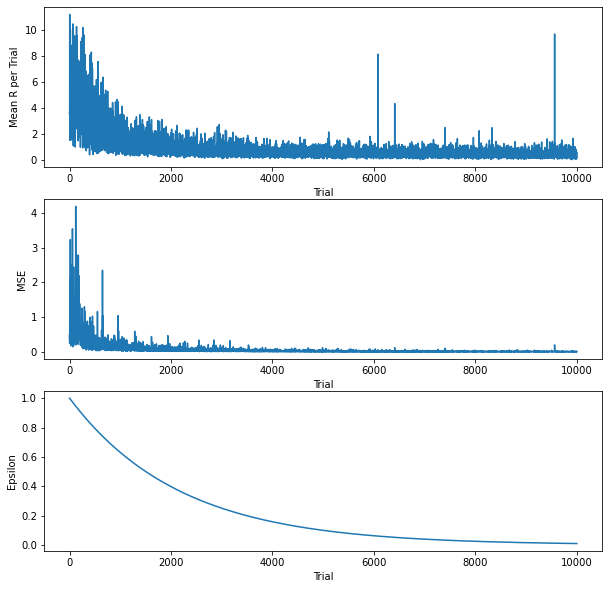

In [276]:
plot_experiment(experiment_1, best_index[0])

There is quite a bit of volatility towards the end of training in `Mean R per Trial` and `MSE` for the Qnet.  Perhaps some additional training might help.  Let's set up a heat map to understand where a new grid search could be directed to improve model performance.

## Set Up the Data Frame to Visualize the Results in a Heat Map

* `mean_last_20_r` needs to be converted to a numeric value
* `n_hiddens_list` needs to be converted to a string for grouping
* Data will be pivoted with `n_opt_iterations` on the columns, `mean_last_20_r` as the values, and the remaining parameter search variables as groups on the rows

In [277]:
# convert mean_last_20_r to numeric for use in pivot table
experiment_1['params'].loc[:,'mean_last_20_r'] = pd.to_numeric(experiment_1['params'].loc[:,'mean_last_20_r'])

# convert n_hiddens_list to string for use in pivot table
nh_string = [str(nh) for nh in experiment_1['params'].loc[:,'n_hiddens_list']]
experiment_1['params']['nh_string'] = nh_string

In [278]:
experiment_1['params'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   act_func           18 non-null     object 
 1   final_epsilon      18 non-null     float64
 2   gamma              18 non-null     float64
 3   learning_rate      18 non-null     float64
 4   n_hiddens_list     18 non-null     object 
 5   n_opt_iterations   18 non-null     int64  
 6   n_steps_per_trial  18 non-null     int64  
 7   n_trials           18 non-null     int64  
 8   polar_coord        18 non-null     bool   
 9   mean_last_20_r     18 non-null     float64
 10  state_funcs        0 non-null      object 
 11  nh_string          18 non-null     object 
dtypes: bool(1), float64(4), int64(3), object(4)
memory usage: 1.7+ KB


In [280]:
index_cols = ['polar_coord', 'act_func', 'nh_string', 'n_trials', 'n_steps_per_trial']
pivot_results = experiment_1['params'].pivot_table(values='mean_last_20_r', 
                                                 index=index_cols,
                                                 columns='n_opt_iterations')
pivot_results

n_opt_iterations                                                  15  \
polar_coord act_func nh_string  n_trials n_steps_per_trial             
False       elu      [256, 256] 10000    256                1.246807   
                     [512, 512] 10000    256                1.294156   
                     [768, 768] 10000    256                1.627134   
True        elu      [256, 256] 10000    256                0.695972   
                     [512, 512] 10000    256                0.651145   
                     [768, 768] 10000    256                0.790522   

n_opt_iterations                                                  35        75  
polar_coord act_func nh_string  n_trials n_steps_per_trial                      
False       elu      [256, 256] 10000    256                0.658740  0.588032  
                     [512, 512] 10000    256                0.550450  0.564696  
                     [768, 768] 10000    256                0.641656  0.709954  
True        elu      [256, 256] 10000    256                0.543085  0.498764  
                     [512, 512] 10000    256                0.411637  0.445211  
                     [768, 768] 10000    256                0.596726  0.808200

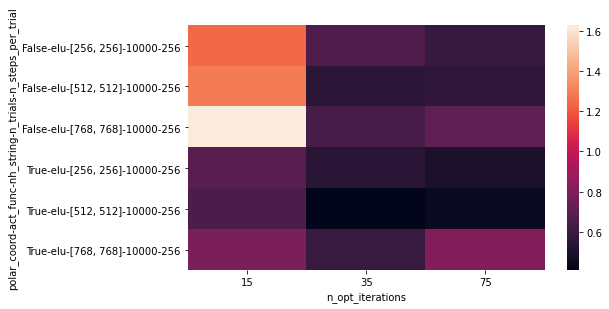

In [281]:
sns.heatmap(pivot_results);

**Thoughts on Heat Map:**
* The models that included polar coordinates in the state space performed better.
* The additional complexity of the [768, 768] model did provide any benefit to learning.
* Additional optimization steps may have improved the results of the [256,256] model which provided results that were pretty close to the [512,512] model.
* Repeating the experiment with more steps per trail and optimization steps might yield further model improvements.

## Examine the Animation to See How Well the Model Learned

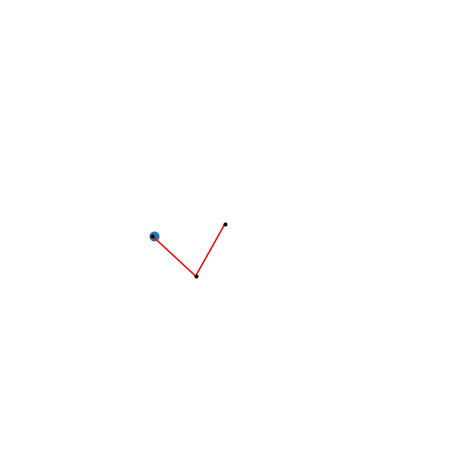

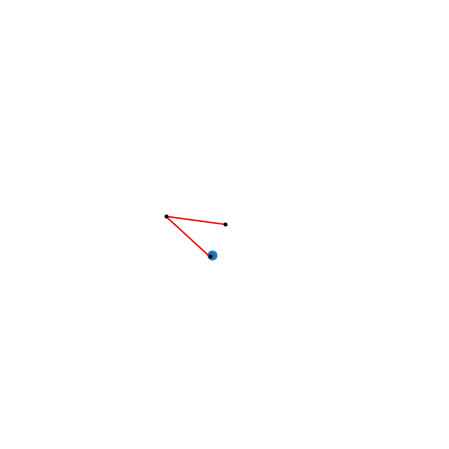

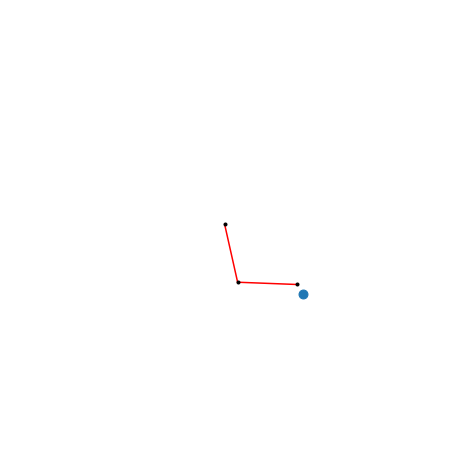

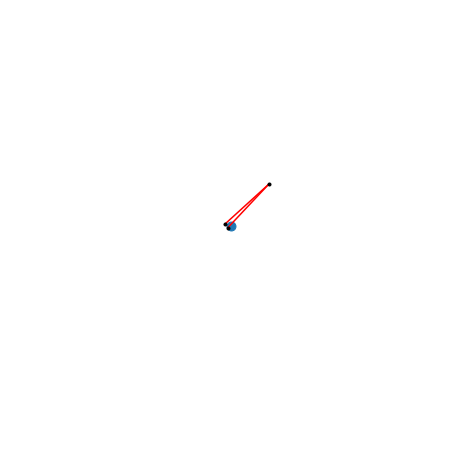

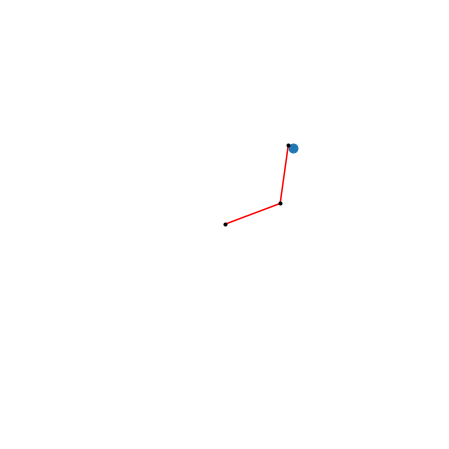

In [282]:
robot = experiment_1['robot']
# get state_funcs based on boolean value of polar_coord
state_funcs = get_state_functions(experiment_1['params'].loc[best_index[0],'polar_coord'])

for i in range(5):
    if random_goal:
        robot.set_rand_goal()
    initial_state(robot)
    robot.animate(50, best_Qnet, state_funcs['state_f'])

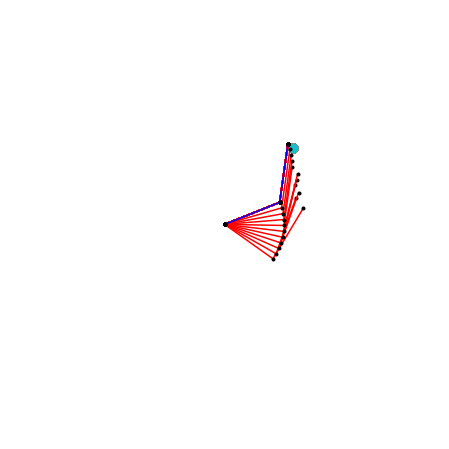

In [283]:
np.random.seed(4444)
initial_state(robot)

robot.animate(100, best_Qnet, state_funcs['state_f'], show_all_steps=True)

## Summary of Experiment 

* Adding polar coordinates is helpful but the model complexity and training steps need to be increased so the model can learn how to use the additional information.

* Slower training, i.e. more steps per trial, helped the models with variable goals learn the best actions for the variable goal state spaces.

* Additional testing with activation functions could be worthwhile.  I did some testing with ELU, ReLU, and Tanh and in these tests ELU performed better but these test were not exhaustive.  Given additional time tuning in the activation functions in the parameter grid would be interesting.

* The ADAM optimizer was used throughout the experiment.  A couple runs were tested using SGD and a couple of learning rate decay strategies but ADAM performed better in this limited testing. This is another area where further testing may prove beneficial.

## Next Steps

### Implement Parallel Training 

Torch has a drop in replacement for Python's `multiprocessing` package. Further work can be directed toward implementing the training function, so it can be run in parallel in order to speed up parameter searching.

https://pytorch.org/docs/master/notes/multiprocessing.html

### Try Building a RL Model for Robots with More Links and More Actions

The action space could be increased from `[-0.1, 0.0, 0.1]` to something like `[-0.1, -0.05, 0.0, 0.05, 0.1]` in order to give the robot greater precision. The number of links could be increased as well in order to give the robot greater flexibility. Each of the these changes will increase the training complexity and training time. Implementing parallel training would help reduce the training time.